In [1]:
from query_graphs.query_graphs import QueryGraphs


query_graphs = QueryGraphs()
query_graph = query_graphs.get_graph_1()

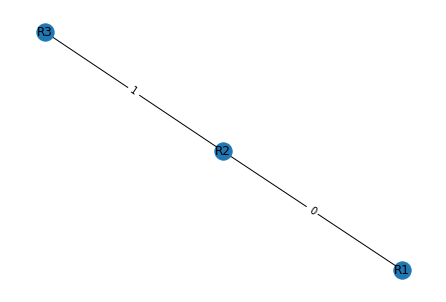

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming pos is the position layout for the nodes
pos = nx.spring_layout(query_graph)

nx.draw(query_graph, pos, with_labels=False)  # Draw nodes and edges
labels = nx.get_node_attributes(query_graph, 'label')  # Assuming 'label' is the attribute name
nx.draw_networkx_labels(query_graph, pos, labels=labels)  # Draw node labels

edge_labels = nx.get_edge_attributes(query_graph, 'label')  # Assuming 'label' is the attribute name
nx.draw_networkx_edge_labels(query_graph, pos, edge_labels=edge_labels)  # Draw edge labels

plt.show()

In [3]:
def merge_two_dicts(x, y):
    res = {}
    for key in x.keys():
        res[key] = x[key]
    for key in y.keys():
        if key in res:
            res[key] += y[key]
        else:
            res[key] = y[key]
    return res

def multiply_two_dicts(x, y):
    res = {}
    for key_x in x.keys():
        for key_y in y.keys():
            union_key = key_x.union(key_y)
            if union_key in res:
                res[union_key] += x[key_x] * y[key_y]
            else:
                res[key_x.union(key_y)] = x[key_x] * y[key_y]
    return res

class BinaryPolynomial:
    
    def __init__(self, binary_variables, relations):
        self.binary_variables = binary_variables
        self.relations = relations
        
    def __add__(self, other):
        result = merge_two_dicts(self.binary_variables, other.binary_variables)
        return BinaryPolynomial(result, self.relations.union(other.relations))
    
    def __mul__(self, other):
        if not isinstance(other, BinaryPolynomial):
            self.binary_variables = {i: self.binary_variables[i] * other for i in self.binary_variables}
            return self
        return BinaryPolynomial(multiply_two_dicts(self.binary_variables, other.binary_variables), self.relations.union(other.relations))
    
    def __str__(self):
        res = ""
        for key in self.binary_variables.keys():
            res += str(self.binary_variables[key]) + "*" + "*".join(key) + '\n'
        return res

In [4]:
def recursive_hubo(query_graph, level, hubo):
    finish_early = False
    for join in query_graph.edges.data():
        
        label = join[2]["label"]
        selectivity = join[2]["selectivity"]
        left_table = join[0]
        right_table = join[1]
        left_cardinality = query_graph.nodes[left_table]["cardinality"]
        right_cardinality = query_graph.nodes[right_table]["cardinality"]
        tables = set([left_table, right_table])
        
        if level == 0:
            coeff = selectivity * left_cardinality * right_cardinality
            variable = f"{label}_{level}"
            bin_var = {frozenset([variable]): coeff} #BinaryVariable(coeff, {variable})
            bin_poly = BinaryPolynomial(bin_var, tables)
            #print((left_table, right_table, level))
            hubo[(left_table, right_table, level)] = bin_poly
        else:
            #print("Level", level) 
            left_bin_polys = {}
            right_bin_polys = {}
            
            # Loop over edges adjacent to left_table
            for left_join in query_graph.edges(left_table):
                #print(left_join)
                left = tuple(sorted(left_join))
                if left[0] != left_table or left[1] != right_table:
                    bin_poly_left = hubo[(left[0], left[1], level-1)]
                    left_bin_polys[left] = bin_poly_left
                    
            for right_join in query_graph.edges(right_table):
                #print(right_join)
                right = tuple(sorted(right_join))
                if right[0] != left_table or right[1] != right_table:
                    bin_poly_right = hubo[(right[0], right[1], level-1)]
                    right_bin_polys[right] = bin_poly_right
            
                 
            final_bin_poly = BinaryPolynomial({}, set())
            
            if len(left_bin_polys) == 0:
                left_bin_polys = {(left_table, right_table) : left_cardinality }
            if len(right_bin_polys) == 0:
                right_bin_polys = {(left_table, right_table) : right_cardinality }
            
            # Multiply all the binary polynomials
            for left_join in left_bin_polys:
                for right_join in right_bin_polys:
                    #print(left_join, right_join)
                    if (left_join[1] == right_join[1] or left_join[0] == right_join[0] or left_join[0] == right_join[1] or left_join[1] == right_join[0]) and (isinstance(left_bin_polys[left_join], BinaryPolynomial) and isinstance(right_bin_polys[right_join], BinaryPolynomial)):
                        
                        
                        # This case is divided into two cases so that they are separate
                        
                        left_bin_poly = left_bin_polys[left_join]
                        right_bin_poly = right_bin_polys[right_join]
                        
                        left_bin_poly_reduced = left_cardinality #BinaryPolynomial([BinaryVariable(left_cardinality, set())], set([left_table])) #hubo[(left_join[0], left_join[1], level-1)]
                        right_bin_poly_reduced = right_cardinality #BinaryPolynomial([BinaryVariable(right_cardinality, set())], set([right_table])) #hubo[(right_join[0], right_join[1], level-1)]
                        
                        current_tables = left_bin_poly.relations.union(right_bin_poly.relations).union(tables)
                        if current_tables == set(query_graph.nodes):
                            finish_early = False
                        
                        current_bin_poly = BinaryPolynomial({frozenset([f'{label}_{level}']) : selectivity }, current_tables)
                        
                        final_bin_poly += left_bin_poly * right_bin_poly_reduced * current_bin_poly
                        final_bin_poly += right_bin_poly * left_bin_poly_reduced * current_bin_poly
                        
                    else:
                        #print("No intersection")
                        left_bin_poly = left_bin_polys[left_join]
                        right_bin_poly = right_bin_polys[right_join]
                        current_tables = tables
                        if isinstance(left_bin_poly, BinaryPolynomial):
                            current_tables = left_bin_poly.relations.union(current_tables)
                        if isinstance(right_bin_poly, BinaryPolynomial):
                            current_tables = right_bin_poly.relations.union(current_tables)
                        if current_tables == set(query_graph.nodes):
                            finish_early = False
                        current_bin_poly = BinaryPolynomial({frozenset([f'{label}_{level}']) : selectivity }, current_tables)
                        if isinstance(left_bin_poly, int):
                            final_bin_poly += right_bin_poly * current_bin_poly * left_bin_poly
                        elif isinstance(right_bin_poly, int):
                            final_bin_poly += left_bin_poly * current_bin_poly * right_bin_poly
                        else:
                            final_bin_poly += left_bin_poly * current_bin_poly * right_bin_poly
            
            hubo[(left_table, right_table, level)] = final_bin_poly
                        
    return hubo, finish_early

In [5]:
hubo = {}
for level in range(len(query_graph.edges) - len(nx.cycle_basis(query_graph))):
    hubo, finish_early = recursive_hubo(query_graph, level, hubo)
    if finish_early:
        break

In [6]:
final_polynomial = BinaryPolynomial({}, set())
for key in hubo:
    final_polynomial += hubo[key]
print(final_polynomial)

100000.0*0_0
20000.0*1_0
20000000.0*0_1*1_0
20000000.0*0_0*1_1



In [7]:
import dimod

# We present level agnostic constraints. We do not impose constraints considering which join should be performed on which level.
# The number of needed joins is exactly
n_joins = len(query_graph.edges) - len(nx.cycle_basis(query_graph))
max_number_of_levels = n_joins
# Performing the joins takes at least as many levels as the number of joins if we perform one join per level. 
# It is possible to perform multiple joins on the same level and we do not impose any constraints regarding that.

variables = []
for i, join in enumerate(query_graph.edges.data()):
    for level in range(max_number_of_levels):
        label = int(join[2]["label"])
        variables.append(f"{label}_{level}")
# Select exactly number of n_joins variables to be 1
combs = dimod.generators.combinations(variables, n_joins, strength=1)

In [8]:
import itertools
# Next we encode the constraint that we cannot perform two joins on the same level if they share a table
bqm_dict = {}
for level in range(max_number_of_levels):
    for table in query_graph.nodes():
        # Loop over edges adjacent to table
        # Access edges with data
        joins = query_graph.edges(table, data=True)
        for join1, join2 in itertools.combinations(joins, 2):
            join1_label = join1[2]['label']
            join2_label = join2[2]['label']
            print(join1, join2)
            bqm_dict[(f"{join1_label}_{level}", f"{join2_label}_{level}")] = 2
            print(bqm_dict)

(1, 0, {'label': '0', 'selectivity': 0.1}) (1, 2, {'label': '1', 'selectivity': 0.2})
{('0_0', '1_0'): 2}
(1, 0, {'label': '0', 'selectivity': 0.1}) (1, 2, {'label': '1', 'selectivity': 0.2})
{('0_0', '1_0'): 2, ('0_1', '1_1'): 2}


In [9]:
# Besides (unfortunately) we have to introduce auxiliary variables so that
# we keep track of the performed joins in total. We are allowed to perform every join only once.

join_dict = {}
for join in query_graph.edges.data():
    label = join[2]["label"]
    aux_var = f"{label}_aux"
    vars = [f"{label}_{level}" for level in range(max_number_of_levels)]
    join_dict[aux_var] = 1
    for var in vars:
        join_dict[(aux_var, var)] = -2
        join_dict[(var,)] = 1
    for var1, var2 in itertools.combinations(vars, 2):
        join_dict[(var1, var2)] = 2

In [10]:
# We should start setting variables true starting from the level 0 and then leaving the upper levels empty if so
level_bqm = dimod.BinaryQuadraticModel(dimod.BINARY)
strength = 1
for level in range(max_number_of_levels):
    strength -= level/max_number_of_levels
    if level == 0:
        vars = [str(join[2]["label"]) + "_" + str(level) for join in query_graph.edges.data()]
        bqm1 = dimod.generators.combinations(vars, max_number_of_levels, strength=1)
        level_bqm.update(bqm1)

In [11]:
import dimod

def binary_polynomial_to_dict(binary_polynomial):
    res = {}
    for key in binary_polynomial.binary_variables.keys():
        if type(key) == str:
            res[tuple([key])] = binary_polynomial.binary_variables[key]
        res[tuple(key)] = binary_polynomial.binary_variables[key]
    return res

hubo_dict = binary_polynomial_to_dict(final_polynomial)
print(hubo_dict)
#hubo_dict = {}
hubo = dimod.BinaryPolynomial(hubo_dict, dimod.BINARY)
hubo.normalize()
print(hubo)

B = 2
for key in combs.linear:
    k = tuple([key])
    if k in hubo:
        hubo[k] += B*combs.linear[key]
    else:
        hubo[k] = B*combs.linear[key]
        
for key in combs.quadratic:
    if key in hubo:
        hubo[key] += B*combs.quadratic[key]
    else:
        hubo[key] = B*combs.quadratic[key]
        
for key in level_bqm.linear:
    k = tuple([key])
    if k in hubo:
        hubo[k] += B*combs.linear[key]
    else:
        hubo[k] = B*combs.linear[key]
        
for key in level_bqm.quadratic:
    if key in hubo:
        hubo[key] += B*combs.quadratic[key]
    else:
        hubo[key] = B*combs.quadratic[key]

for key in bqm_dict:
    if key in hubo:
        hubo[key] += B*bqm_dict[key]
    else:
        hubo[key] = B*bqm_dict[key]
        
for key in join_dict:
    if type(key) == str:
        k = tuple([key])
        if k in hubo:
            hubo[k] += B*join_dict[key]
        else:
            hubo[k] = B*join_dict[key]
    else:
        if key in hubo:
            hubo[key] += B*join_dict[key]
        else:
            hubo[key] = B*join_dict[key]
        
#print(hubo)

{('0_0',): 100000.0, ('1_0',): 20000.0, ('0_1', '1_0'): 20000000.0, ('0_0', '1_1'): 20000000.0}
BinaryPolynomial({frozenset({'0_0'}): 0.005, frozenset({'1_0'}): 0.001, frozenset({'0_1', '1_0'}): 1.0, frozenset({'0_0', '1_1'}): 1.0}, 'BINARY')


In [12]:
# Solve with polysolver
print(hubo)
sampleset = dimod.ExactPolySolver().sample_poly(hubo)
print(sampleset.first.energy)
for var, value in sampleset.first.sample.items():
    if value == 1 and "aux" not in var:
        print(var)

BinaryPolynomial({frozenset({'0_0'}): -9.995000000000001, frozenset({'1_0'}): -9.998999999999999, frozenset({'0_1', '1_0'}): 5.0, frozenset({'0_0', '1_1'}): 5.0, frozenset({'0_1'}): -4.0, frozenset({'1_1'}): -4.0, frozenset({'0_0', '0_1'}): 8.0, frozenset({'0_0', '1_0'}): 12.0, frozenset({'0_1', '1_1'}): 8.0, frozenset({'1_1', '1_0'}): 8.0, frozenset({'0_aux'}): 2, frozenset({'0_0', '0_aux'}): -4, frozenset({'0_aux', '0_1'}): -4, frozenset({'1_aux'}): 2, frozenset({'1_aux', '1_0'}): -4, frozenset({'1_aux', '1_1'}): -4}, 'BINARY')
-12.998999999999999
0_1
1_0
